In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy   as np
import sklearn as skl

import matplotlib.pyplot as plt
import seaborn           as srn

from scipy.optimize import minimize, check_grad

from sklearn.model_selection       import train_test_split
from sklearn.metrics               import pairwise_distances
from sklearn.svm                   import OneClassSVM
from sklearn.kernel_approximation  import RBFSampler, Nystroem

from scipy.stats                   import beta

We will compare several different methods on a toy problem, where data is drawn from a Beta(2,2) distribution:
* sklearn OC-SVM optimisation with a cosine transformation of the inputs
* explicit OC-SVM optimisation with a cosine transformation of the inputs
* explicit OC-NN optimisation with a cosine activation and fixed input-hidden weights
* explicit OC-NN optimisation with a cosine activation and learned input-hidden weights
* background contrast optimisation with a cosine transformation of the inputs

The reason for a cosine transformation is to mimic the behaviour of the RBF kernel, per the random Fourier features idea.

In [2]:
np.random.seed(42)
N = 2 * 10**4
D = 1

X     = beta.rvs(a = 2, b = 2, size = N)[:,np.newaxis]
pStar = lambda x: beta.pdf(x, a = 2, b = 2)

XTr, XTe = train_test_split(X, train_size = 0.80, random_state = 42)
XTe      = XTe[np.argsort(XTe.flatten()),:]

/Users/akmenon/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [3]:
nu = 0.75

In [4]:
gMed = 100 * 1/np.median(pairwise_distances(XTr, XTr)**2)

K = 500
C = np.sqrt(np.sqrt(gMed/np.pi)) # used for normalisation of kernel

# explicitly compute random Fourier features per Rahimi and Recht
R = np.sqrt(2 * gMed) * np.random.normal(0, 1, (D, K))
b = 2 * np.pi * np.random.uniform(0, 1, (1, K))

XTrTrans = C * np.sqrt(2/K) * np.cos(XTr.dot(R) + b)
XTeTrans = C * np.sqrt(2/K) * np.cos(XTe.dot(R) + b)
XBG      = C * np.sqrt(2/K) * np.cos(np.random.uniform(0, 1, XTr.shape).dot(R) + b)

# rff = Nystroem(gamma = gMed, n_components = 500, random_state = 42)
# rff.fit(XTr)

# XTrTrans = C * rff.transform(XTr)
# XTeTrans = C * rff.transform(XTe)
# XBG      = C * rff.transform(np.random.uniform(0, 1, XTr.shape))

## Explicit OC-SVM style optimisation

In [11]:
def relu(x):
    y = x
    y[y < 0] = 0
    return y

def dRelu(x):
    y = x
    y[x <= 0] = 0
    y[x > 0]  = np.ones((len(x[x > 0]),))
    return y

In [12]:
def svmScore(X, w):
    return X.dot(w)

def ocsvm_obj(theta, X, nu):
    
    w = theta[:-1]
    r = theta[-1]
    
    term1 = 0.5 * np.sum(w**2)
    term2 = 1/nu * np.mean(relu(r - svmScore(X, w)))
    term3 = -r
    
    return term1 + term2 + term3

def ocsvm_grad(theta, X, nu):
    
    w = theta[:-1]
    r = theta[-1]
    
    deriv = dRelu(r - svmScore(X, w))

    term1 = np.append(w, 0)
    term2 = np.append(1/nu * np.mean(deriv[:,np.newaxis] * (-X), axis = 0),
                      1/nu * np.mean(deriv))
    term3 = np.append(0*w, -1)

    grad = term1 + term2 + term3
    
    return grad

In [13]:
theta0 = np.random.normal(0, 1, K + 1)
print('Gradient error: %s' % check_grad(ocsvm_obj, ocsvm_grad, theta0, XTrTrans, nu))

resEXP = minimize(ocsvm_obj, theta0, 
                  jac     = ocsvm_grad, 
                  args    = (XTrTrans, nu),
                  method  = 'L-BFGS-B',                
                  options = {'gtol': 1e-8, 'disp': True, 'maxiter' : 50000, 'maxfun' : 10000})

Gradient error: 4.3371199677155346e-05


In [14]:
wEXP = resEXP.x[:-1]
rEXP = resEXP.x[-1]

## Explicit OC-NN style optimisation

In [15]:
V  = R
bH = b

g  = lambda x : +C * np.sqrt(2/K) * np.cos(x)
dG = lambda x : -C * np.sqrt(2/K) * np.sin(x)

def hiddenScore(X, V, g):
    return g(X.dot(V) + bH)

def nnScore(X, w, V, g):
    return hiddenScore(X, V, g).dot(w)

In [16]:
def ocnn_obj(theta, X, nu, D, K, g, dG):
    
    w = theta[:K]
    r = theta[-1]
    
    term1 = 0.5  * np.sum(w**2)
    term2 = 0
    term3 = 1/nu * np.mean(relu(r - nnScore(X, w, V, g)))
    term4 = -r
    
    return term1 + term2 + term3 + term4

def ocnn_grad(theta, X, nu, D, K, g, dG):
    
    N = X.shape[0]
    w = theta[:K]
    r = theta[-1]
    
    deriv = dRelu(r - nnScore(X, w, V, g))    

    term1 = np.concatenate(( w,
                             np.zeros((1,)) ))

    term2 = np.concatenate(( np.zeros((w.size,)),
                             np.zeros((1,)) ))

    term3 = np.concatenate(( 1/nu * np.mean(deriv[:,np.newaxis] * (-hiddenScore(X, V, g)), axis = 0),
                             1/nu * np.array([ np.mean(deriv) ]) ))
    
    term4 = np.concatenate(( np.zeros((w.size,)),
                             -1 * np.ones((1,)) ))
    
    return term1 + term2 + term3 + term4

In [17]:
theta0 = np.random.normal(0, 1, K + 1)
#theta0 = resEXP.x

print('Gradient error: %s' % check_grad(ocnn_obj, ocnn_grad, theta0, XTr, nu, D, K, g, dG))
resNN = minimize(ocnn_obj, theta0, 
                 jac     = ocnn_grad, 
                 args    = (XTr, nu, D, K, g, dG),
                 method  = 'L-BFGS-B',                
                 options = {'gtol': 1e-8, 'disp': True, 'maxiter' : 50000, 'maxfun' : 10000})

Gradient error: 2.8364197922481357e-05


In [18]:
wNN = resNN.x[:-1]
rNN = resNN.x[-1]

In [ ]:
# print(ocsvm_obj(resNN.x, XTrTrans, nu))
# print(ocsvm_obj(resEXP.x, XTrTrans, nu))

In [ ]:
# print(ocnn_obj(resNN.x, XTr, nu, D, K, g, dG))
# print(ocnn_obj(resEXP.x, XTr, nu, D, K, g, dG))

In [ ]:
# print(np.sum(ocsvm_grad(resNN.x, XTrTrans, nu)**2))
# print(np.sum(ocsvm_grad(resEXP.x, XTrTrans, nu)**2))

In [ ]:
# print(np.sum(ocnn_grad(resNN.x, XTr, nu, D, K, g, dG)**2))
# print(np.sum(ocnn_grad(resEXP.x, XTr, nu, D, K, g, dG)**2))

## Explicit OC-NN style _full_ optimisation

In [ ]:
def fhiddenScore(X, V, bH, g):
    return g(X.dot(V) + bH)

def fnnScore(X, w, V, bH, g):
    return fhiddenScore(X, V, bH, g).dot(w)

In [ ]:
def ocfnn_obj(theta, X, nu, D, K, g, dG):
    
    w  = theta[:K]
    V  = theta[K:K+K*D].reshape((D, K))
    bH = theta[K+K*D:K+K*D+K]
    r  = theta[-1]
    
    term1 = 0.5  * np.sum(w**2)
    term2 = 0.5  * np.sum(V**2)
    term3 = 1/nu * np.mean(relu(r - fnnScore(X, w, V, bH, g)))
    term4 = -r
    
    return term1 + term2 + term3 + term4

def ocfnn_grad(theta, X, nu, D, K, g, dG):
    
    N  = X.shape[0]
    w  = theta[:K]
    V  = theta[K:K+K*D].reshape((D, K))
    bH = theta[K+K*D:K+K*D+K]
    r  = theta[-1]
    
    deriv = dRelu(r - fnnScore(X, w, V, bH, g))    

    term1 = np.concatenate(( w,
                             np.zeros((V.size,)),
                             np.zeros((bH.size,)),
                             np.zeros((1,)) ))

    term2 = np.concatenate(( np.zeros((w.size,)),
                             V.flatten(),
                             np.zeros((bH.size,)),
                             np.zeros((1,)) ))

    term3 = np.concatenate(( 1/nu * np.mean(deriv[:,np.newaxis] * (-fhiddenScore(X, V, bH, g)), axis = 0),
                             1/nu * np.mean((deriv[:,np.newaxis] * (dG(X.dot(V) + bH) * -w)).reshape((N, 1, K)) * X.reshape((N, D, 1)), axis = 0).flatten(),
                             1/nu * np.mean((deriv[:,np.newaxis] * (dG(X.dot(V) + bH) * -w)).reshape((N, 1, K)) * np.ones((N, D, 1)), axis = 0).flatten(),
                             1/nu * np.array([ np.mean(deriv) ]) ))
    
    term4 = np.concatenate(( np.zeros((w.size,)),
                             np.zeros((V.size,)),
                             np.zeros((bH.size,)),
                             -1 * np.ones((1,)) ))
    
    return term1 + term2 + term3 + term4

In [ ]:
theta0 = np.random.normal(0, 1, K + K*D + K + 1)
#theta0 = resEXP.x

print('Gradient error: %s' % check_grad(ocfnn_obj, ocfnn_grad, theta0, XTr, nu, D, K, g, dG))
resFNN = minimize(ocfnn_obj, theta0, 
                  jac     = ocfnn_grad, 
                  args    = (XTr, nu, D, K, g, dG),
                  method  = 'L-BFGS-B',                
                  options = {'gtol': 1e-8, 'disp': True, 'maxiter' : 50000, 'maxfun' : 10000})

In [ ]:
wFNN = resFNN.x[:K]
VFNN = resFNN.x[K:K+K*D].reshape((D,K))
bFNN = resFNN.x[K+K*D:K+K*D+K]
rFNN = resFNN.x[-1]

## Background contrast optimisation

In [5]:
def properObj(theta, XPos, XNeg, nu, gam, mu):

    w = theta[:-1][:,np.newaxis]
    r = theta[-1]

    term1 = np.maximum(r - XPos.dot(w), 0)
    term2 = mu * 0.5 * (XNeg.dot(w))**2
    term3 = -nu * r

    return np.mean(term1) + np.mean(term2) + term3 + (gam/2) * np.sum(w**2)


def properGrad(theta, XPos, XNeg, nu, gam, mu):

    w = theta[:-1][:,np.newaxis]
    r = theta[-1]

    term1  = r - XPos.dot(w)
    gradH  = (term1 > 0).astype(int) + 0.0 * (term1 == 0).astype(int)
    
    gradW1 = gradH * (-XPos)
    gradR1 = gradH * 1
    
    gradW2 = mu * (XNeg.dot(w)) * XNeg
    gradR2 = np.array([0])

    gradW3 = np.array([0])
    gradR3 = np.array([-nu])

    gradW = np.mean(gradW1,axis = 0).flatten() + \
            np.mean(gradW2,axis = 0).flatten() + \
            gradW3 + \
            gam * w.flatten()
    gradR = np.mean(gradR1) + \
            np.mean(gradR2) + \
            gradR3

    grad  = np.concatenate([ gradW.flatten(), gradR.flatten() ])

    return grad

In [6]:
theta0 = np.random.normal(0, 1, K + 1)

res = minimize(lambda w : properObj(w, XTrTrans, XBG, nu, 1e-2, 1), 
               theta0,
               jac = lambda w : properGrad(w, XTrTrans, XBG, nu, 1e-2, 1),
               tol = 1e-16)

wBG = res.x[:-1]
rBG = res.x[-1]

## sklearn optimisation

In [7]:
#ocSKL = OneClassSVM(nu = nu, kernel = 'rbf', gamma = gMed)
#ocSKL.fit(XTr)

ocSKL = OneClassSVM(nu = nu, kernel = 'linear')
ocSKL.fit(XTrTrans)

#print(ocsvm_grad(np.concatenate([ ocSKL.coef_/(nu * XTr.shape[0]), [ ocSKL.intercept_/(nu * XTr.shape[0]) ] ]).flatten(), XTr, nu, D))

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto',
      kernel='linear', max_iter=-1, nu=0.75, random_state=None,
      shrinking=True, tol=0.001, verbose=False)

## Comparison of predictions

In [19]:
ocEXPScores = svmScore(XTeTrans, wEXP) - rEXP
ocNNScores  = nnScore(XTe, wNN, V, g) - rNN
#ocFNNScores = fnnScore(XTe, wFNN, VFNN, bFNN, g) - rFNN
ocBGScores  = XTeTrans.dot(wBG) - rBG
ocSKLScores = (ocSKL.decision_function(XTeTrans).flatten())/(nu * XTr.shape[0])

In [9]:
srn.set(font_scale = 2);

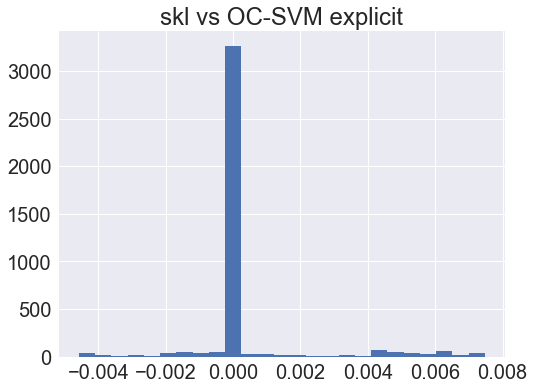

In [20]:
plt.figure(figsize = (8,6));
plt.hist(ocEXPScores - ocSKLScores, bins = 25);
plt.title('skl vs OC-SVM explicit');

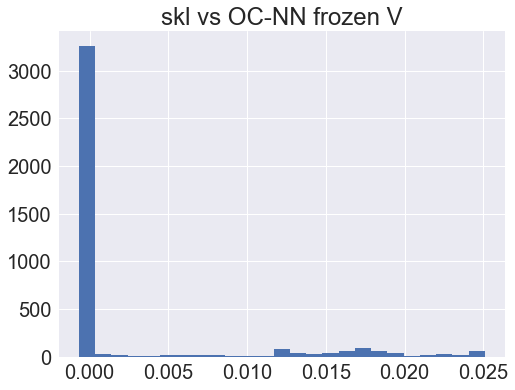

In [21]:
plt.figure(figsize = (8,6));
plt.hist(ocNNScores - ocSKLScores, bins = 25);
plt.title('skl vs OC-NN frozen V');

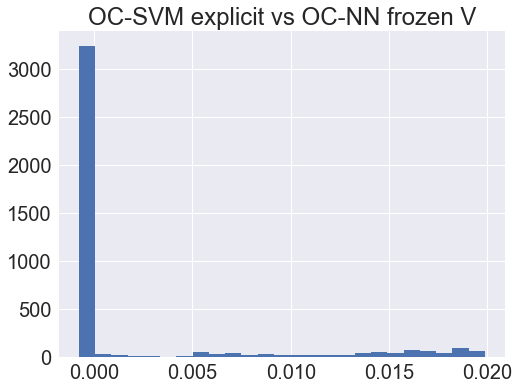

In [22]:
plt.figure(figsize = (8,6));
plt.hist(ocNNScores - ocEXPScores, bins = 25);
plt.title('OC-SVM explicit vs OC-NN frozen V');

In [ ]:
plt.figure(figsize = (8,6));
plt.hist(ocFNNScores - ocSKLScores, bins = 25);
plt.title('skl vs OC-NN learned V');

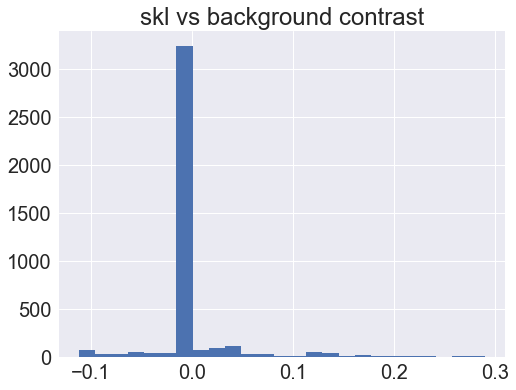

In [23]:
plt.figure(figsize = (8,6));
plt.hist(ocBGScores - ocSKLScores, bins = 25);
plt.title('skl vs background contrast');

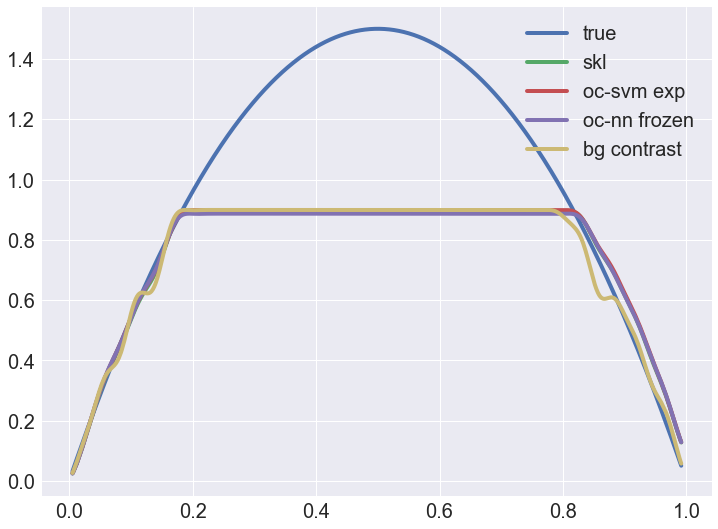

In [33]:
plt.figure(figsize = (12, 9));
plt.plot(XTe, pStar(XTe), linewidth = 4)
plt.plot(XTe, nu * (ocSKLScores - ocSKL.intercept_/(nu*XTr.shape[0])), linewidth = 4)
plt.plot(XTe, nu * (ocEXPScores + rEXP), linewidth = 4)
plt.plot(XTe, nu * (ocNNScores + rNN), linewidth = 4)
#plt.plot(XTe, nu * (ocFNNScores + rFNN))
plt.plot(XTe, ocBGScores + rBG, linewidth = 4)

plt.legend(['true', 
            'skl', 
            'oc-svm exp', 
            'oc-nn frozen', 
            #'oc-nn learned', 
            'bg contrast'],
          loc = 'upper right');